# NLP Method: A Bridge from Federal Reserve Meeting Minutes to US Treasury Markets

# Project Objective

The objective of this project is to apply NLP methods on texts published by Federal Reserve Open Market Committee (FOMC) to quantify the communications in a systematic manner and find the relationship with Treasury
yield curve.

# Project Background

Financial Markets react to many kinds of information, such as GDP growth and unemployment rate. Traditionally, such quantitative factors can be easily included in trading or investment models, which provide market practitioners signals. However, along with the rise of Deep Learning, qualitative factors play more and more important roles in the investment world. One main category among qualitative factors is language analysis based on NLP. The wording in policies from government, especially regulators, such as Federal Reserve, is a perfect example.


Unlike certain NLP models, which may be able to achieve 90%+ accuracy, models predicting directions of financial market movements are very challenging. Usually, 60%-70% accuracy is good performance, and 70%+ accuracy may help one secure a job in hedge fund.

# Target Problem

FOMC has eight regular meetings per year to determine U.S. monetary policy. Fed policy is based on current economy environment and the forecasted situations. Meanwhile, the policy itself also impacts future economy. The endogenous relationship between policy and reality makes their cause-effect relationship complicated. After each FOMC meeting, Fed publishes press conference minutes, statements, as well as scripts in text, as a result, the market regularly observes significant volatility around FOMC meetings. However, because the complexity of real-world financial markets, it is not straightforward to quantify the exact impact from FOMC meeting on markets.

# Table of Contents


1. [Data Overview](#data-o)
    <br>1.1 [Summary](#sum)
    <br>1.2 [Sections](#t-sect)
    <br>1.3 [Crop Sections](#crop)
    <br>1.4 [Treaaury Rates](#rates)

2. [Data Pre-processing](#data-p)
    <br>2.1 [Tokenization](#stemlem)

3. [Topic Modelling](#topic-m)
    <br>3.1 [Non-negative matrix factorization](#nmf)
    <br>3.2 [Latent Dirichlet Allocation](#lda)
 
4. [Sentiment Analysis](#sent-a)
    <br>4.1 [Dictionary Approach](#dict)
    <br>4.2 [Sentiment Extraction](#sent-e)
    
5. [Modeling](#model)
    <br>5.1 [Correlations](#corr)
    <br>5.1 [Baseline Model](#base)
    <br>5.2 [GloVe Embeddings](#glove)
    <br>5.3 [Elmo Embeddings](#elmo)
    <br>5.4 [Bert Embeddings](#bert)
    <br>5.4 [Use Entire Minutes](#minutes)

6. [Deployment](#deploy)

7. [Future Work](#future)





In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

In [2]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -r drive/My\ Drive\/fednlp/requirements.txt
    file_path_prefix = './drive/My Drive/fednlp/'
    
    import torch
    device = torch.device("cuda:0")
else:
    file_path_prefix = '/Users/aaroncgw/Google Drive/fednlp/'

In [3]:
import re
import os,sys
import calendar
import datetime
from datetime import timedelta
from collections import Counter
import dill as pickle

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


import nltk
from nltk.corpus import CategorizedPlaintextCorpusReader
nltk.download('punkt')
from wordcloud import WordCloud
import spacy
from spacy.lang.en import English
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer    

!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()

[nltk_data] Downloading package punkt to /Users/aaroncgw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


You should consider upgrading via the '/Users/aaroncgw/Google Drive/fednlp/my_env/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


# <a name="data-o"></a> Data Overview
There are two components of the data. One is FOMC meeting minutes (text) and one is Treasury yield curve (numerical).

Meeting minutes data was web scrapped from https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm.
The year 2004 was chosen as the start-year given the acceleration of release dates to 3 weeks, and improved clarity in explanations of committee’s decisions and views [(Danker,2005)](https://www.federalreserve.gov/pubs/bulletin/2005/spring05_fomc.pdf)

Treasury yield curve is obtained from U.S. Department of The Treasury offical site: https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield

## <a name="sum"></a>Minutes Summary

In [4]:
corpus_root = file_path_prefix + 'data/minutes'
data_m = CategorizedPlaintextCorpusReader(corpus_root, r'.*\.txt', cat_pattern=r'(\w+)/*')
data_fileids = data_m.fileids()

print('Total number of files: '+str(len(data_m.fileids())))
print('Number of paragraphs: '+str(len(data_m.paras())))
print('Number of sentences: '+str(len(data_m.sents())))
print('Number of words: '+str(len(data_m.words())))
print('\n'+'First file: '+ data_fileids[0])
print('Last file: '+ data_fileids[-1])

Total number of files: 131
Number of paragraphs: 16006
Number of sentences: 41414
Number of words: 1126076

First file: 2004/20040128.txt
Last file: 2020/20200610.txt


<AxesSubplot:xlabel='index', ylabel='Average number of words'>

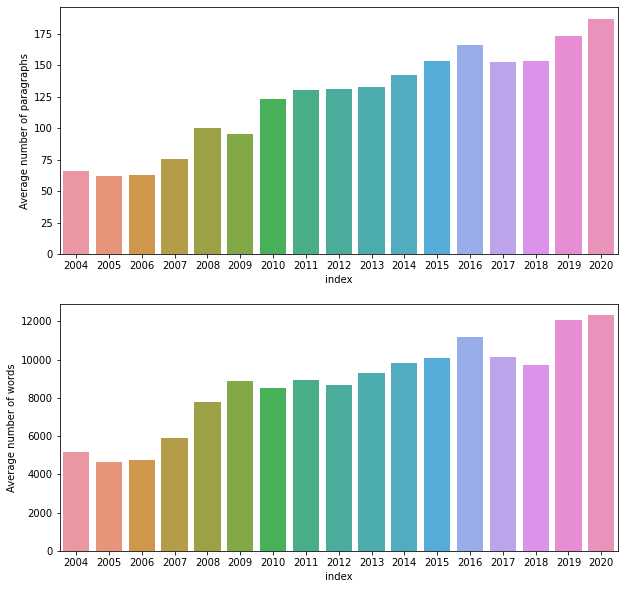

In [5]:
num_para_py = {}
num_word_py = {}

for y in range(2004,2021):
    files = data_m.fileids(str(y))
    files_size = len(files)
    num_para_py[y] = sum([len(data_m.paras(f))for f in files])/files_size
    num_word_py[y] = sum([len(data_m.words(f))for f in files])/files_size
        
para_words = pd.DataFrame([num_para_py,num_word_py],
                          index = ['Average number of paragraphs','Average number of words']).T

para_words = para_words.reset_index()

fig,ax = plt.subplots(2, 1, figsize=(10,10))
sns.barplot(x="index", y="Average number of paragraphs", data=para_words, ax=ax[0])
sns.barplot(x="index", y="Average number of words", data=para_words, ax=ax[1])

We can see an acceleration in the numbers of paragraphs and words overtime. Before the Global Finance Crisis (GFC 2008), FOMC minutes were 60 ~ 75 paragraphs, and between 4500 ~ 6000 words. After the crisis, monetary policy became more important to US economy. FOMC members need to address more aspects on policy consequences. Since last year, the minutes have been extended even longer because of increased complexicity from both the peaking of current economic cycle and massive internal trade conflicts.

## <a name="t-sect"></a> Sections
The minutes are split into 4 sections (see [Background on FOMC Meeting Minutes](https://www.federalreserve.gov/pubs/bulletin/2005/spring05_fomc.pdf)) 

1. Introduction
2. Economic and financial information
3. Participants’ views on developments 
4. Policy decisions

The first set of introductory paragraphs contain a list of attendees and procedural items, which are not of use to our analysis and hence need to be removed. The next problem to tackle is knowing when to start the minutes from.

Text(0, 0.5, 'Word count')

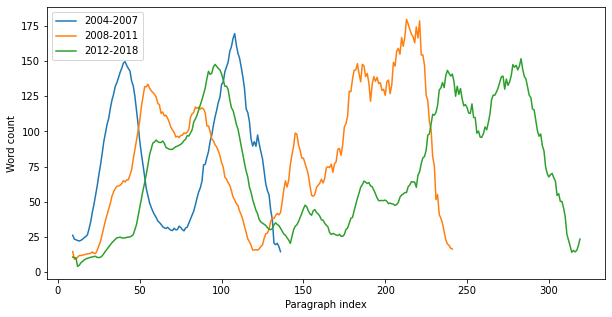

In [6]:
df_temp = pd.DataFrame()
df_year = pd.DataFrame()
for y in range(2004,2019):
    files = data_m.fileids(str(y))
    for f in files:
        word_para = [sum([len(s)for s in p]) for p in data_m.paras(f)]
        df_temp = pd.concat([df_temp,pd.Series(word_para,name=f)],axis=1)
    
    df_mean = df_temp.mean(axis=1)
    df_mean.name = y
    df_year= pd.concat([df_year,df_mean],axis=1)
    df_temp = df_temp.iloc[0:0]

window_size = 10

y1 = df_year.loc[:,[y for y in range(2004,2008)]].mean(axis=1).rolling(window_size).mean()
y2 = df_year.loc[:,[y for y in range(2009,2012)]].mean(axis=1).rolling(window_size).mean()
y3 = df_year.loc[:,[y for y in range(2012,2019)]].mean(axis=1).rolling(window_size).mean()

df_joint = pd.DataFrame([y1,y2,y3],index = ['2004-2007','2008-2011','2012-2018']).T


ax = df_joint.plot(figsize=(10,5))
ax.set_xlabel("Paragraph index")
ax.set_ylabel("Word count")

To see how the mintues are structured, we can plot a moving average of words per paragraph. The peaks and troughs of this moving average are indicative of new sections, where usually the start of the section includes a header or a very few words. 

For simplicity, we have identified three different types of structures that span from 2004-2007, 2008-2011 and 2012-2018 respectively. It is quite clear that the early minutes (2004-2007) began it's second section at paragraph 30-40, whilst those minutes later on began at paragraph 50 or onwards.

## <a name="crop"></a>Crop Sections

Given that we know where sections roughly start, the easiest way to split our sections is to find the most common words. For our analysis, the minutes will start with phrases similar to 'Staff Review of the Economic Situation' or 'The information reviewed' and end on 'At the conclusion of this meeting' or 'The Committee voted to authorize'.

In [7]:
corpus_root_cropped = file_path_prefix + 'data/minutes_cropped'
data_c = CategorizedPlaintextCorpusReader(corpus_root_cropped, r'.*\.txt', cat_pattern=r'(\w+)/*')

print('Total number of files: '+str(len(data_c.fileids())))
print('Number of paragraphs: '+str(len(data_c.paras())))
print('Number of sentences: '+str(len(data_c.sents())))
print('Number of words: '+str(len(data_c.words())))

Total number of files: 131
Number of paragraphs: 5422
Number of sentences: 24232
Number of words: 733281


After we filter out relevant information, total number of paragraphs, sentences and words are reduced by 30-60%.

## <a name="rates"></a>Treasury Rates

US Treasury rates represent the market yields of the debts (bill and bonds) issued by the US Treasury Department. These yields are essentially the "price" of these debts. Yields are usually different for debts maturing at different times. Market practitioners mostly focus on 3-month, 2-year, 5-year and 10-year maturities. With yields from different maturities, we can build a yield curve.

Yield spread represents the difference between short term (usually 3-month) and long term (usually 10-year) yields (10y yield minus 3m yield). The change of spread indicates market sentiment of Fed monetary policy, which is based on forecast of future economic conditions. When change of spread is positive, it is called yield curve steepening. Otherwise, it is called flattening.

In [8]:
with open(file_path_prefix + 'data/rates/rates_daily.pickle', 'rb') as handle:
    rates_daily = pickle.load(handle)
    
with open(file_path_prefix + 'data/rates/rates_monthly.pickle', 'rb') as handle:
    rates_monthly = pickle.load(handle)

In [9]:
n_day = 5
df_yc_slope_changes = pd.DataFrame((rates_daily['BC_10YEAR'] - rates_daily['BC_3MONTH']), columns=['slope_change']).diff(n_day).shift(-n_day)[:-n_day]
df_yc_slope_changes['steepen'] = df_yc_slope_changes['slope_change'] > 0


# <a name="data-p"></a> Data Pre-processing



## <a name="stemlem"></a> Tokenization

To enhance topic modelling output, we can remove stop words and reduce inflectional forms of words back to its roots - using techniques such as stemming and lemmatization. 


In [10]:
en = English()

def simple_tokenizer(doc, model=en):
    tokenized_docs = []
    parsed = model(doc)
    return([t.lemma_.lower() for t in parsed if (t.is_alpha)&(not t.like_url)&(not t.is_stop)])

In [11]:
def last_day_of_month(any_day):
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)  # this will never fail
    return next_month - datetime.timedelta(days=next_month.day)

In [12]:
idx = []
paragraph_list = []
for f in data_c.fileids():
    year,month,day = re.search("(\d{4})(\d{2})(\d{2})",f).groups()
    paragraph_list_single_file = data_c.raw(f).split("\n\n")
    for paragraph_number, paragraph in enumerate(paragraph_list_single_file):
        p_tokenized = simple_tokenizer(paragraph)
        if len(p_tokenized) != 0:
            idx.append((datetime.datetime(int(year), int(month), int(day)) + datetime.timedelta(days=21), paragraph_number)) #minutes are usually 21 days after meetings
            paragraph_list.append([p_tokenized,paragraph])
        
df_paragraphs = pd.DataFrame(data = paragraph_list,
                      index = pd.MultiIndex.from_tuples(idx), 
                      columns = ['tokenized_text','raw_text'])

print(len(df_paragraphs))
df_paragraphs.head()

5422


tokenized_text  \
2004-02-18 0  [committee, turned, discussion, economic, outl...   
           1  [economy, appeared, expanded, robust, pace, fo...   
           2  [december, employment, report, suggested, labo...   
           3  [pace, expansion, industrial, sector, picked, ...   
           4  [sales, light, vehicles, jumped, december, fou...   

                                                       raw_text  
2004-02-18 0  The Committee then turned to a discussion of t...  
           1   The economy appeared to have expanded at a ro...  
           2   The December employment report suggested that...  
           3   The pace of expansion in the industrial secto...  
           4   Sales of light vehicles jumped in December, a...

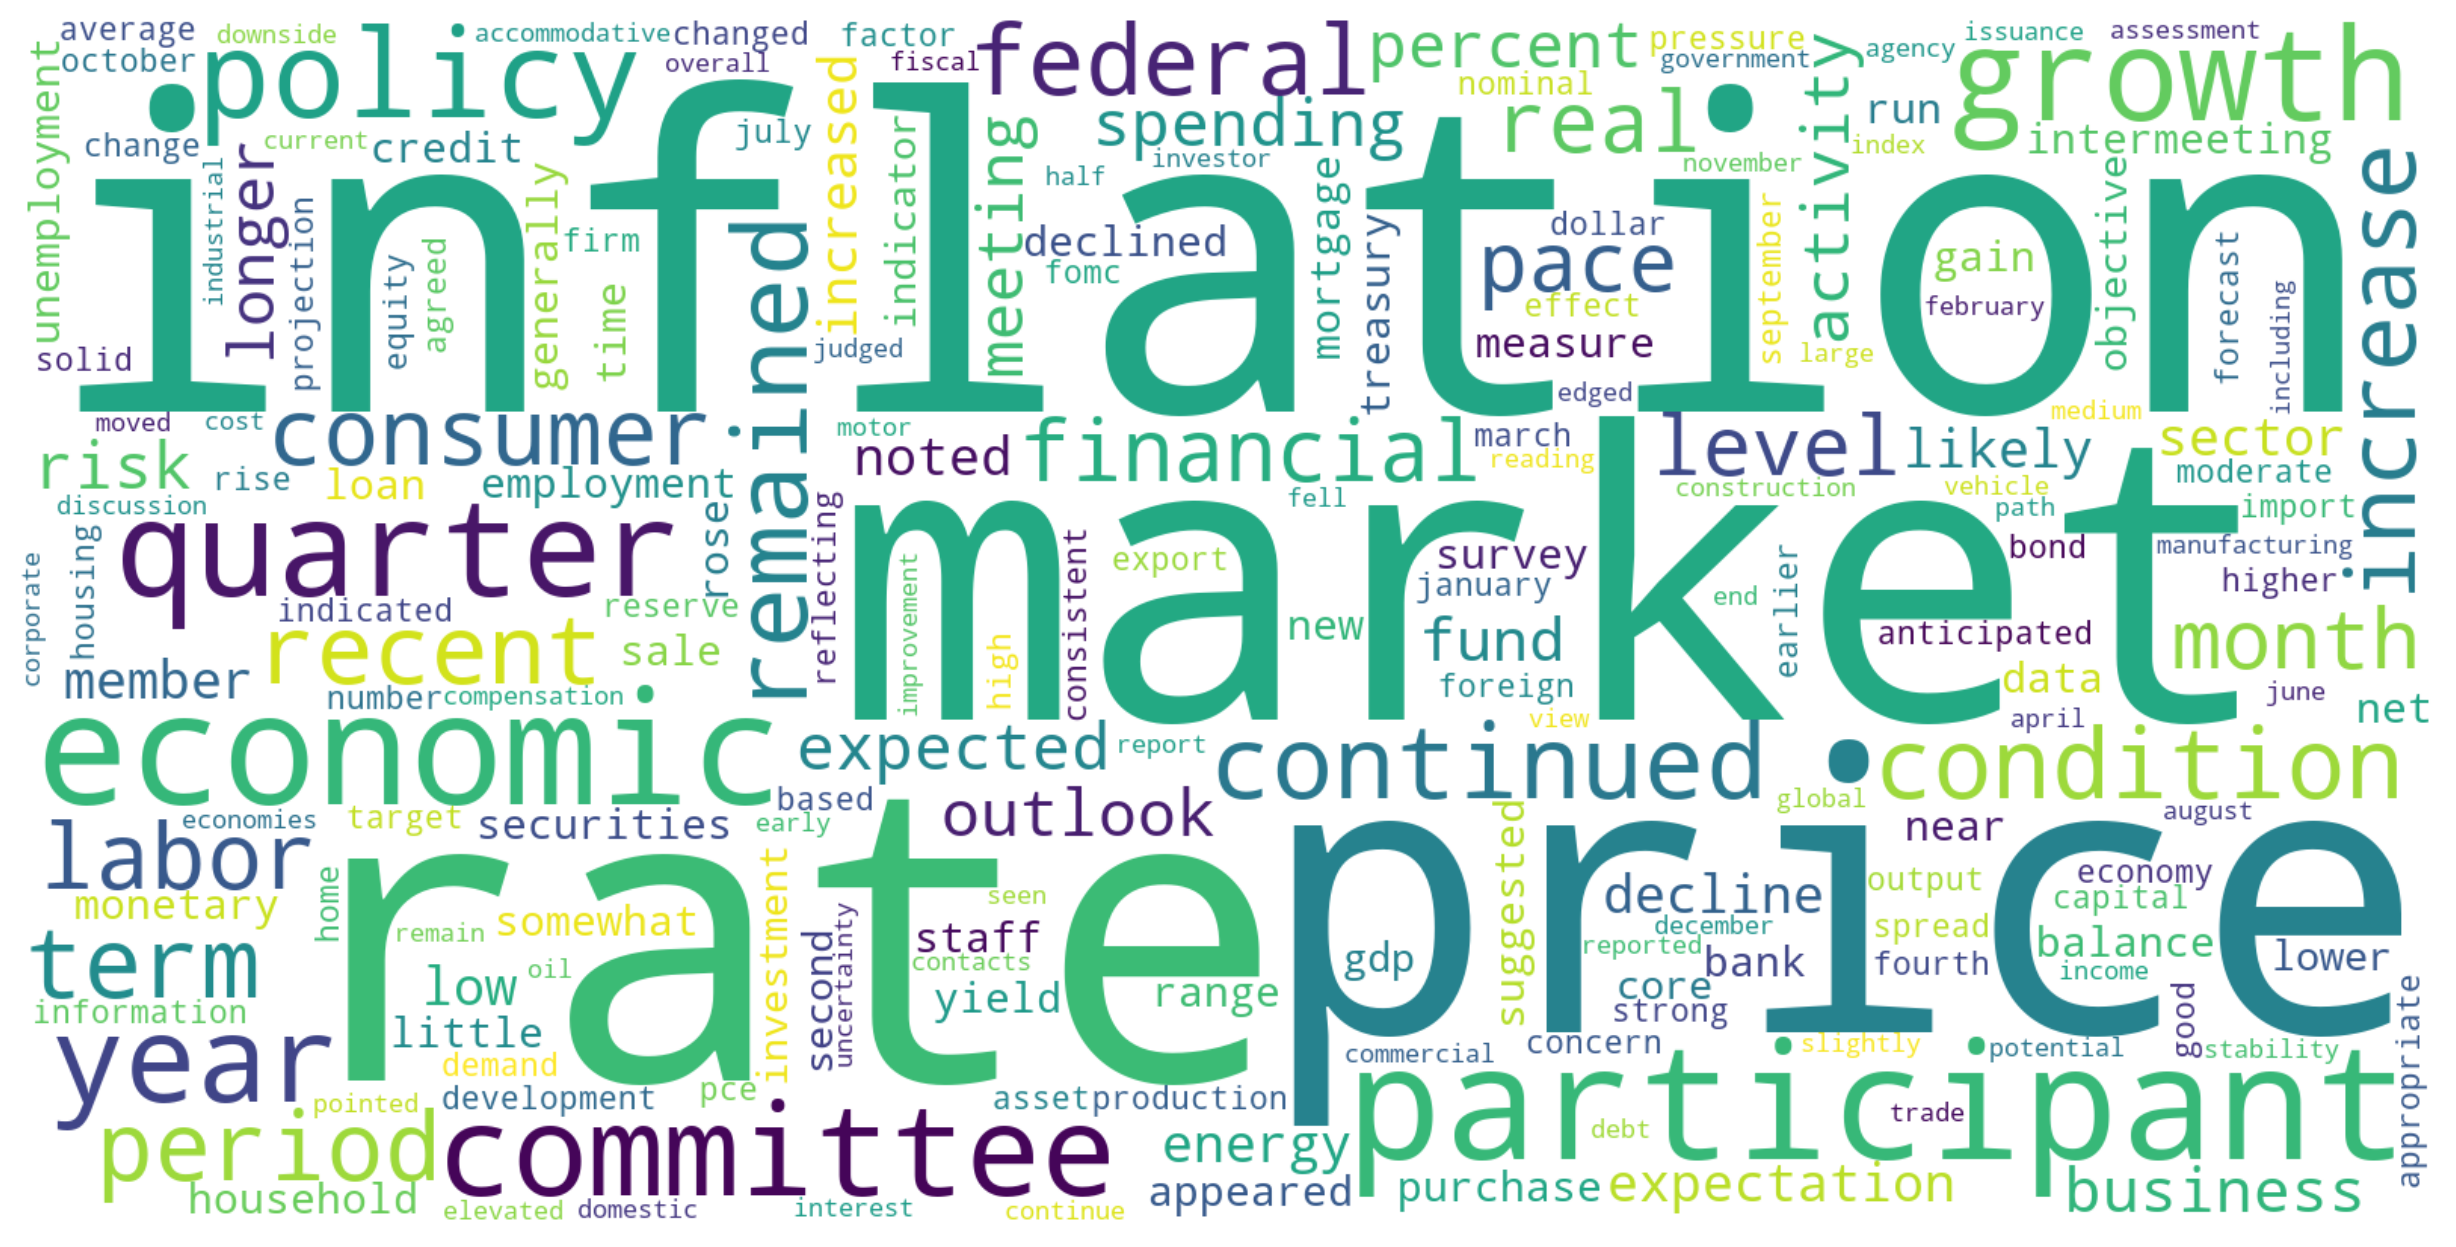

In [13]:
#Most frequent words in corpus
tokenized_text = df_paragraphs['tokenized_text']
all_tokens = [item for sublist in tokenized_text for item in sublist]

wordcloud = WordCloud(collocations=False,
                      background_color='white',
                      mode='RGB',
                      width=1600, height=800).generate((" ").join(all_tokens))

fig = plt.figure(figsize=(16,8),dpi=200)
plt.axis('off')
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

The Wordcloud chart above summarizes the top words from the meeting minutes. Not surprisingly, it implies the two mandates Fed has: controling inflation and maintaining growth and employment.

# <a name="topic-m"></a>Topic Modelling 

Now that we have our clean text corpus, we can create a bag of words and pass it into a Latent Dirichlet Allocation model (LDA). This probabilistic model is ideal for our analysis as each paragraph is distributed amongst a set of topics, where topics themselves are defined by words that frequently appear with each other. 

<br>
In our previous example, the phrase "Labor market conditions continued to strengthen in recent months, with the unemployment rate declining further and payroll gains well above a pace consistent with maintaining a stable unemployment rate over time" is one that belongs in the labour market category. Additionally, one might say words like labour, payroll and unemployment are more likely to appear in the same document (or in this case paragraph). 

In [14]:
def summarize_topics(model, feature_names, no_top_words):
    topics = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i]for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics["Topic %d:" % (topic_idx)] = top_words
    return topics

num_topics = 6

## <a name="nmf"></a>NMF

In [15]:
tfidf = TfidfVectorizer(tokenizer = lambda x: x, lowercase = False)
tfidf_fitted = tfidf.fit_transform(list(tokenized_text))

nmf = NMF(n_components = num_topics, random_state=7).fit(tfidf_fitted)
nmf_t = nmf.transform(tfidf_fitted)

print("Cosine similiarity of all paragraphs: %.4f." % cosine_similarity(nmf_t).mean(axis=1).mean())

Cosine similiarity of all paragraphs: 0.4807.


## <a name="lda"></a>LDA

One of the most important inputs in the LDA model is the number of topics (n_components). Given that this is an unsupervised task, there is no best way to choose this input other than trial and error - which in this case results to n_components = 6. 

In [16]:
count_vecs = CountVectorizer(tokenizer = lambda x: x, lowercase = False)
count_vecs_fitted = count_vecs.fit_transform(list(tokenized_text))

lda = LatentDirichletAllocation(n_components = num_topics, random_state=7).fit(count_vecs_fitted)
lda_t = lda.transform(count_vecs_fitted)

print("Cosine similiarity of all paragraphs: %.4f." % cosine_similarity(lda_t).mean(axis=1).mean())

Cosine similiarity of all paragraphs: 0.2977.


The cosine_similiarity of LDA is smaller than NMF and we use LDA as our topic modeling method.

/Users/aaroncgw/Google Drive/fednlp/my_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Cosine Similiarity of paragraphs in each minutes'}>

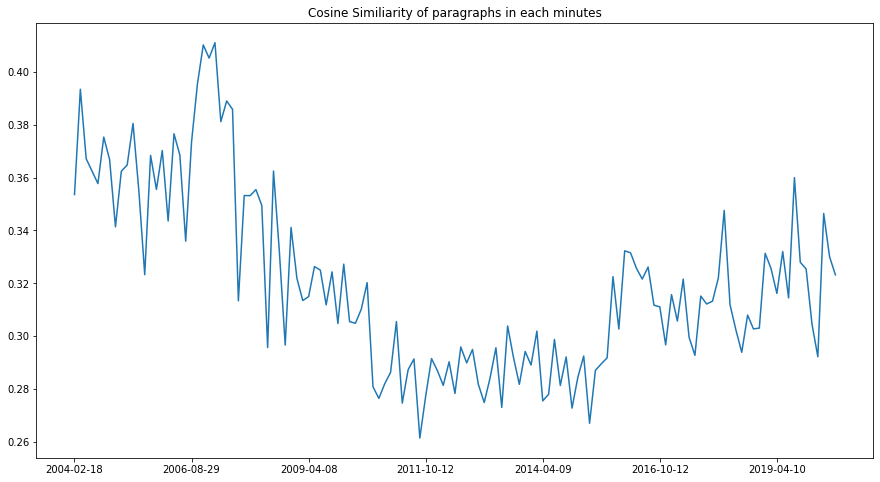

In [17]:
df_paragraphs['topic_weights'] = list(lda_t)

df_lda_vecs_doc = df_paragraphs['topic_weights'].groupby(level=0).apply(np.array)
df_lda_vecs_doc = df_lda_vecs_doc.apply(lambda x: cosine_similarity(np.vstack(x)).mean(axis=1).mean())
df_lda_vecs_doc.index = [str(ts)[:10] for ts in list(df_lda_vecs_doc.index)]
df_lda_vecs_doc.plot(figsize=(15,8), title="Cosine Similiarity of paragraphs in each minutes")

The cosine similarity in each minutes were decresing after 2008.

In [18]:
lda_topic_top_words = summarize_topics(lda,count_vecs.get_feature_names(),10)
lda_topic_top_words

,Topic 0:,Topic 1:,Topic 2:,Topic 3:,Topic 4:,Topic 5:
0,prices,committee,real,period,inflation,quarter
1,remained,federal,quarter,yields,participants,business
2,inflation,policy,consumer,intermeeting,economic,spending
3,consumer,rate,gdp,financial,growth,sector
4,loans,funds,spending,market,labor,production
5,credit,market,growth,treasury,outlook,rate
6,continued,members,second,foreign,market,sales
7,price,conditions,income,markets,recent,continued
8,months,target,forecast,spreads,expected,remained
9,survey,range,pace,equity,prices,months


The output above shows the top 10 words associated to each topic. Some topics are more distinguishable than others, where words such as inflation, price and energy are usually associated to the topic 'Inflation', whilst others are less so.

In [19]:
#Dictionary with topics
topic_dict = {0 : 'Inflation',
              1 : 'Economic Policy',
              2 : 'Growth Outlook', 
              3 : 'Financial Market',
              4 : 'Labor Market', 
              5 : 'Investment'}
topic_dict

{0: 'Inflation',
 1: 'Economic Policy',
 2: 'Growth Outlook',
 3: 'Financial Market',
 4: 'Labor Market',
 5: 'Investment'}

In [20]:
def sum_prop(x):
    x_sum = x.sum(axis=0)
    return (x_sum/x_sum.sum())*100

df_topic_t = df_paragraphs.groupby(level=[0],sort=False)['topic_weights']\
                        .apply(lambda x: sum_prop(x)).apply(pd.Series)\
                        .rename(columns = topic_dict)

df_topic_m = df_topic_t.groupby(level=[0],sort=False).apply(lambda x: sum_prop(x))
topic_perc = df_topic_m.divide(df_topic_m.sum(axis=1), axis=0)

In [21]:
df_topic_m.head()

,Inflation,Economic Policy,Growth Outlook,Financial Market,Labor Market,Investment
2004-02-18,6.424245,19.376254,9.232912,9.430513,23.693131,31.842945
2004-04-06,5.243547,16.277947,9.060297,9.962377,23.616621,35.839211
2004-05-25,7.898664,15.844626,7.644670,9.467879,25.896429,33.247732
2004-07-21,9.201395,15.986722,10.165280,8.130873,23.811100,32.704630
2004-08-31,8.396560,16.213567,12.123760,6.986213,24.062308,32.217591


Text(0.5, 1.0, 'Topic Percentage Over Time')

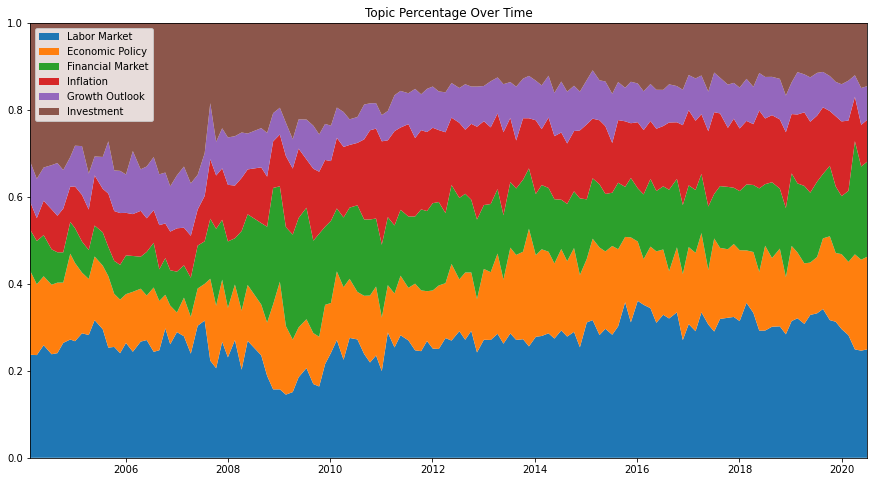

In [22]:
fig, ax = plt.subplots(figsize=(15,8))
ax.stackplot(df_topic_m.index,  topic_perc["Labor Market"],  topic_perc["Economic Policy"],  topic_perc["Financial Market"], 
              topic_perc["Inflation"],  topic_perc["Growth Outlook"],  topic_perc["Investment"],
              labels=['Labor Market','Economic Policy','Financial Market', 'Inflation', 'Growth Outlook', 'Investment'])
ax.legend(loc='upper left')
ax.margins(0,0)
ax.set_title('Topic Percentage Over Time')

The shift of topic weights is reasonable. After Global Financial Crisis, the stability of 'Financial Market' gained more attention from the Fed.

To date, the largest topics are 'Economic Policy' and 'Financial Market'. Considering the sharp turn-around on monetary policy and volatile financial market in the first quarter of 2020, this outcome is within expectation.

We also notice the smallest topic currently is 'Economic Growth'. It doesn't necessary mean Fed cares less about this topic. This is probably due to certain overlap between this topic and other main topics. Again, the topics are not mutual exclusion between each other.

# <a name="sent-a"></a> Sentiment Analysis 

Two sets of dictionaries were used in this section: 
1. Havard IV-4 Psychosociological 
2. Loughran and McDonald

The former is less tailored to financial statements, whilst Loughran and McDonald is adapted to include words from 10-K documents (annual financial reports of publicly listed companies).

Given the lack of labelled data, a very simplistic approach is used to calculate sentiment tone: 

\begin{equation*}
Net \ Tone \  = \frac{\#Positive\ words - \#Negative\ words}
                    {\#Positive\ words + \#Negative\ words} \times \frac{1}{\#Total\ words}
\end{equation*}

Where <br>

Net tone > 0 points to a positive tone
<br>
Net tone < 0 points to a negative tone
<br>
Net tone = 0 points to neutral tone


##  <a name="dict"></a> Dictionary Approach 

Text(0.5, 1.0, 'top negative words')

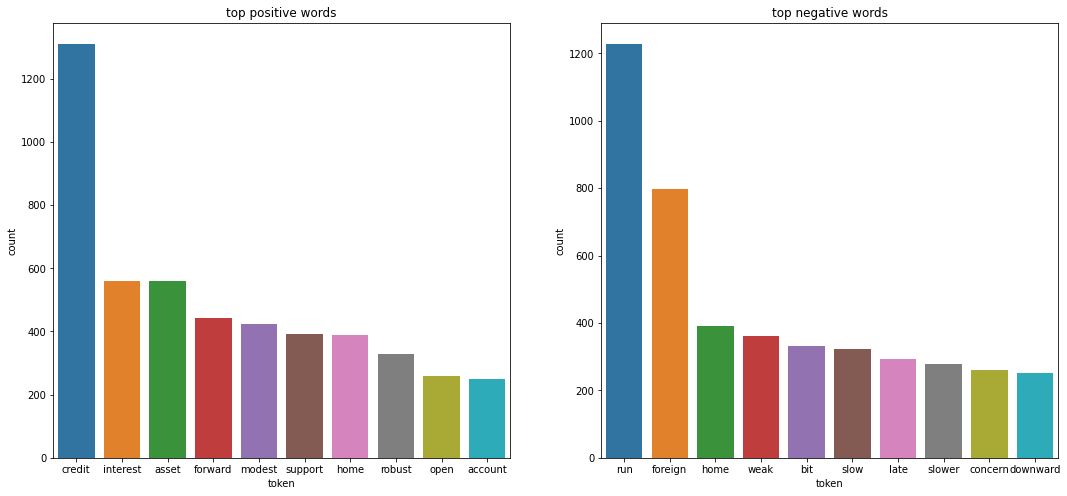

In [23]:
with open(file_path_prefix + 'data/sentiment/sentiment_pos_dict.pickle', 'rb') as handle:
    posDict = pickle.load(handle)
    
with open(file_path_prefix + 'data/sentiment/sentiment_neg_dict.pickle', 'rb') as handle:
    negDict = pickle.load(handle)


corpus_wcount = Counter([item for sublist in tokenized_text for item in sublist])
pos_inter = Counter({w:corpus_wcount[w] for w in posDict.intersection(corpus_wcount)})
neg_inter = Counter({w:corpus_wcount[w] for w in negDict.intersection(corpus_wcount)})

top_pos = pos_inter.most_common(10)
top_neg = neg_inter.most_common(10)

df_top_pos = pd.DataFrame(top_pos, columns=['token', 'count'])
df_top_neg = pd.DataFrame(top_neg, columns=['token', 'count'])

fig, ax = plt.subplots(1,2, figsize=(18,8))
sns.barplot(x="token", y="count", data=df_top_pos, ax=ax[0])
ax[0].set_title('top positive words')
sns.barplot(x="token", y="count", data=df_top_neg, label='top negative words', ax=ax[1])
ax[1].set_title('top negative words')

These are the top 10 positive and negative words that appear in the corpus. Certain words clearly express strong sentiment, such as "support", "robust", "weak" or "slow". Others might not sound so intuitively. The reason is that official wording, especially that from regulators, tends to avoid directly influencing the financial markets. People need to read between the lines. This "feeling" may require years of markets experience for a human being to gain. However, NLP may be able to learn it in a fast and systematic way.

In [24]:
print("Number of positive words in corpus: " +str(sum(pos_inter.values())))
print("Number of negative words in corpus: " +str(sum(neg_inter.values())))

Number of positive words in corpus: 11269
Number of negative words in corpus: 9218


## <a name="sent-e"></a> Sentiment Extraction

In [25]:
def RetrieveScore(tokenized_para,positive,negative): 
    pos_sum = 0
    neg_sum = 0
    score = 0
    if len(tokenized_para) <8:
        return 0
    for word in tokenized_para: 
        if word in positive:
            pos_sum +=1
        elif word in negative:
            neg_sum +=1
    try:
        score = ((pos_sum-neg_sum)/(pos_sum+neg_sum))*(1/len(tokenized_para)) #should this be 
    except ZeroDivisionError:
        score = 0
    return score

df_paragraphs['sentiment_score'] = df_paragraphs.apply(lambda x: RetrieveScore(x['tokenized_text'],posDict,negDict),axis=1)

/Users/aaroncgw/Google Drive/fednlp/my_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

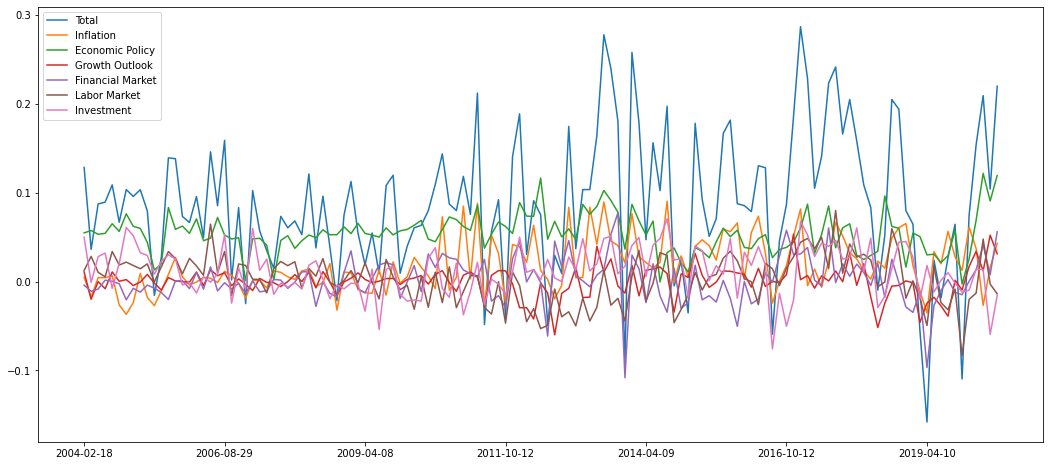

In [26]:
df_sentiment = (df_paragraphs['sentiment_score']*df_paragraphs['topic_weights']).apply(pd.Series).rename(columns = topic_dict)
df_sentiment = pd.concat([df_sentiment.sum(axis=1).rename('Total'),df_sentiment],axis=1)
df_sentiment_m = df_sentiment.groupby(level = [0],sort=False).apply(lambda x: x.sum())
df_sentiment_m.index = [str(ts)[:10] for ts in list(df_sentiment_m.index)]
df_sentiment_m.plot(figsize=(18,8))

The downside of using such a simplistic approach in calculating sentiment is that it can produce some anomalies, in particular for the 'inflation' topic. The word 'inflation' is negative but context is very important when classifying sentiment - in this case the sentence 'Inflation slowed down' should be a positive phrase but is classified as negative. Nevertheless, we can observe a joint dip amongst all topics in 2008, relating to the financial crisis. 

# <a name="model"></a>Modeling

In this section, we build a basedline model and develop more sophisticated models. We split the data into train and test sets. We will compare the accuracy on both for baseline and more sophisticated models.

## <a name="corr"></a>Correlations

In [27]:
combined_df = df_sentiment_m.join(df_yc_slope_changes['slope_change'])
combined_df.corr()

,Total,Inflation,Economic Policy,Growth Outlook,Financial Market,Labor Market,Investment,slope_change
Total,1.000000,0.559449,0.521011,0.464246,0.553919,0.529400,0.513860,0.009485
Inflation,0.559449,1.000000,0.122259,0.198955,0.138029,-0.031722,0.200932,-0.008334
Economic Policy,0.521011,0.122259,1.000000,0.155203,0.374250,0.032395,0.070340,-0.042646
Growth Outlook,0.464246,0.198955,0.155203,1.000000,0.104590,0.265746,0.009593,0.089794
Financial Market,0.553919,0.138029,0.374250,0.104590,1.000000,0.158347,-0.025186,0.133051
Labor Market,0.529400,-0.031722,0.032395,0.265746,0.158347,1.000000,0.230355,0.008256
Investment,0.513860,0.200932,0.070340,0.009593,-0.025186,0.230355,1.000000,-0.120288
slope_change,0.009485,-0.008334,-0.042646,0.089794,0.133051,0.008256,-0.120288,1.000000


In [28]:
combined_df = combined_df[~combined_df['slope_change'].isna()]
combined_df

,Total,Inflation,Economic Policy,Growth Outlook,Financial Market,Labor Market,Investment,slope_change
2004-02-18,0.128530,0.004854,0.054799,0.010789,-0.004165,0.012366,0.049887,-0.33
2004-04-06,0.036279,-0.017494,0.057425,-0.019999,-0.011004,0.028321,-0.000971,-0.30
2004-05-25,0.087339,0.004365,0.053188,-0.000103,-0.008514,0.010366,0.028037,0.03
2004-07-21,0.089421,0.004307,0.054279,-0.008127,0.001545,0.005355,0.032062,-0.29
2004-08-31,0.108835,0.006562,0.065094,0.010818,0.000195,0.033864,-0.007699,0.41
...,...,...,...,...,...,...,...,...
2019-10-09,0.064500,0.027926,0.057527,0.001449,-0.012193,-0.008533,-0.001677,0.20
2019-11-20,-0.109765,0.012689,-0.002798,-0.009409,-0.014874,-0.083475,-0.011898,-0.01
2020-02-19,0.154079,0.037053,0.069084,0.033951,0.013303,-0.013083,0.013770,-0.18
2020-05-20,0.104211,0.015969,0.090714,0.052179,0.007751,-0.002871,-0.059531,-0.01


In [29]:
print(scipy.stats.spearmanr(combined_df['Total'], combined_df['slope_change']))
print(scipy.stats.spearmanr(combined_df['Labor Market'], combined_df['slope_change']))
print(scipy.stats.spearmanr(combined_df['Economic Policy'], combined_df['slope_change']))
print(scipy.stats.spearmanr(combined_df['Financial Market'], combined_df['slope_change']))
print(scipy.stats.spearmanr(combined_df['Inflation'], combined_df['slope_change']))
print(scipy.stats.spearmanr(combined_df['Growth Outlook'], combined_df['slope_change']))
print(scipy.stats.spearmanr(combined_df['Investment'], combined_df['slope_change']))

SpearmanrResult(correlation=-0.04363422251653285, pvalue=0.6261854316188378)
SpearmanrResult(correlation=0.01968593321994634, pvalue=0.8261227356227164)
SpearmanrResult(correlation=-0.0577864164727175, pvalue=0.5187194782238456)
SpearmanrResult(correlation=0.13536715597626497, pvalue=0.12916053387218715)
SpearmanrResult(correlation=-0.11904130689371126, pvalue=0.18252904205609696)
SpearmanrResult(correlation=0.014275231038809304, pvalue=0.8734394736345492)
SpearmanrResult(correlation=-0.17154005826791635, pvalue=0.053809921638164886)


Investment and Financial Market are significant with the changes of the spreads.

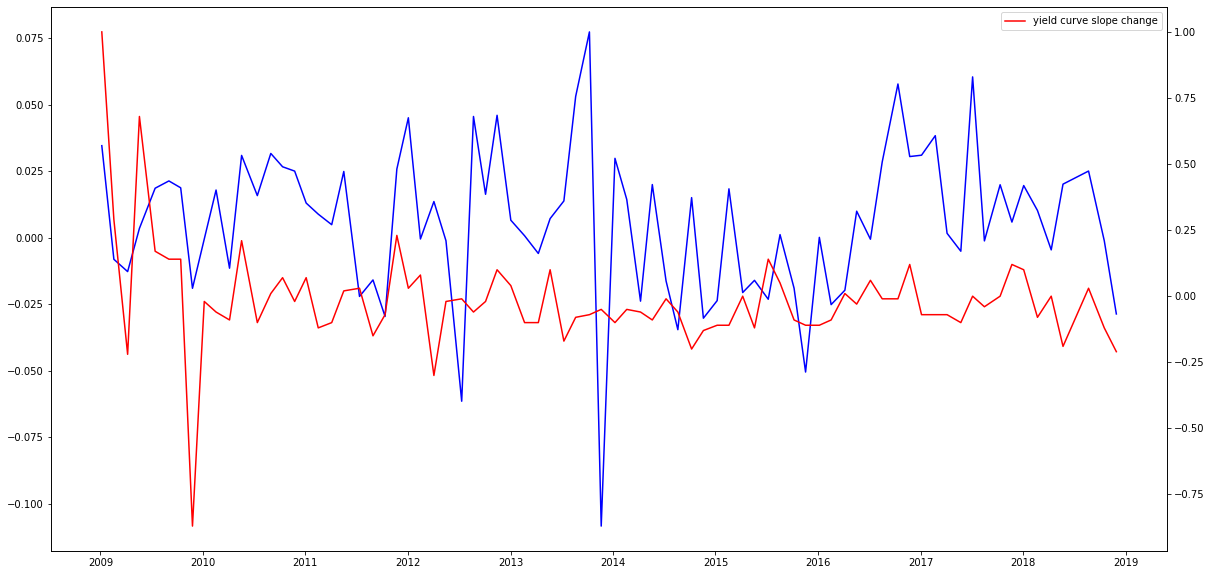

In [30]:
fig, ax_left = plt.subplots(figsize=(20,10))
ax_right = ax_left.twinx()

ax_left.plot(combined_df['Financial Market']["2009":"2018"], color='blue', label='Financial Market')
ax_right.plot(combined_df['slope_change']["2009":"2018"], color='red', label='yield curve slope change')
plt.legend()

## <a name="base"></a>Baseline Models

The baseline model we choose include basic word count and topic models: Tfidf, NMF and LDA. They represent fundamental natural language process methodologies, which analyze word counts and topics of documents.

In [31]:
df_paragraphs_unstack = df_paragraphs.copy()
timestamps = df_paragraphs.index.map(lambda x: str(x[0]))
paragragh_numbers = df_paragraphs.index.map(lambda x: str(x[1]))
df_paragraphs_unstack['paragragh_number'] = paragragh_numbers
df_paragraphs_unstack.index = timestamps
df_paragraphs_unstack = df_paragraphs_unstack.join(df_yc_slope_changes)
df_paragraphs_unstack = df_paragraphs_unstack[~df_paragraphs_unstack['slope_change'].isna()]

In [32]:
x = df_paragraphs_unstack['raw_text']
y = df_paragraphs_unstack['steepen'].astype('bool')

indices = list(range(len(y)))
paragraph_train, paragraph_test, is_steepen_train, is_steepen_test, indices_train, indices_test = train_test_split(x, y, indices, test_size=0.3, random_state=7)
print(len(paragraph_test))
print(len(is_steepen_test))

1573
1573


In [33]:
is_steepen_train.describe()

count      3670
unique        2
top       False
freq       2302
Name: steepen, dtype: object

The label was not balanced. There're more false labes than true lables. Thus, we passed class_weight='balanced' in trainning in order to address the issuse.

In [34]:
pipe = Pipeline([('vectorizer', CountVectorizer(tokenizer=simple_tokenizer)), ('svc', SVC(random_state=42, class_weight='balanced'))])
pipe.fit(paragraph_train, is_steepen_train)
print("Count Train accuracy: ", pipe.score(paragraph_train, is_steepen_train))
print("Count Test accuracy: ", pipe.score(paragraph_test, is_steepen_test))
print(classification_report(is_steepen_test, pipe.predict(paragraph_test)))

Count Train accuracy:  0.8572207084468665
Count Test accuracy:  0.6255562619198983
              precision    recall  f1-score   support

       False       0.69      0.71      0.70       978
        True       0.51      0.48      0.49       595

    accuracy                           0.63      1573
   macro avg       0.60      0.60      0.60      1573
weighted avg       0.62      0.63      0.62      1573



In [35]:
pipe = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=simple_tokenizer)), ('svc', SVC(random_state=42, class_weight='balanced'))])
pipe.fit(paragraph_train, is_steepen_train)
print("Tfidf Train accuracy: ", pipe.score(paragraph_train, is_steepen_train))
print("Tfidf Test accuracy: ", pipe.score(paragraph_test, is_steepen_test))
print(classification_report(is_steepen_test, pipe.predict(paragraph_test)))

Tfidf Train accuracy:  0.8967302452316076
Tfidf Test accuracy:  0.631277813095995
              precision    recall  f1-score   support

       False       0.70      0.71      0.70       978
        True       0.51      0.50      0.51       595

    accuracy                           0.63      1573
   macro avg       0.61      0.61      0.61      1573
weighted avg       0.63      0.63      0.63      1573



In [36]:
pipe = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=simple_tokenizer)), ('topics', NMF(n_components=6, random_state=7)), ('svc', SVC(random_state=42, class_weight='balanced'))])
pipe.fit(paragraph_train, is_steepen_train)
print("NMF Train accuracy: ", pipe.score(paragraph_train, is_steepen_train))
print("NMF Test accuracy: ", pipe.score(paragraph_test, is_steepen_test))
print(classification_report(is_steepen_test, pipe.predict(paragraph_test)))

NMF Train accuracy:  0.5272479564032697
NMF Test accuracy:  0.5104895104895105
              precision    recall  f1-score   support

       False       0.64      0.47      0.55       978
        True       0.40      0.57      0.47       595

    accuracy                           0.51      1573
   macro avg       0.52      0.52      0.51      1573
weighted avg       0.55      0.51      0.52      1573



In [37]:
pipe = Pipeline([('vectorizer', CountVectorizer(tokenizer=simple_tokenizer)), ('topics', LatentDirichletAllocation(n_components=6, random_state=7)), ('svc', SVC(random_state=42, class_weight='balanced'))])
pipe.fit(paragraph_train, is_steepen_train)
print("LDA Train accuracy: ", pipe.score(paragraph_train, is_steepen_train))
print("LDA Test accuracy: ", pipe.score(paragraph_test, is_steepen_test))
print(classification_report(is_steepen_test, pipe.predict(paragraph_test)))

LDA Train accuracy:  0.5583106267029972
LDA Test accuracy:  0.5486331849968213
              precision    recall  f1-score   support

       False       0.66      0.56      0.61       978
        True       0.42      0.53      0.47       595

    accuracy                           0.55      1573
   macro avg       0.54      0.54      0.54      1573
weighted avg       0.57      0.55      0.56      1573



The baseline model we choose include basic word count and topic models: Count, Tfidf, NMF and LDA. Their test accuracy is similar, around 60-63%. Notably, Tfidf generates has the best accuracy and we use it as our benchmark to compare more advanced models.

## <a name="glove"></a>GloVe Embeddings 

Beyond baseline models, we first explore word embeddings, which use pretrained vectors to represent inputs.

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [38]:
vocab = set([value for valueList in paragraph_train.apply(simple_tokenizer).values for value in valueList])
vocab.add('_UNK')
vocab.add('_PAD')

print("Size of vocab:", len(vocab))

glove_dict = dict()
for k in vocab:
    glove_dict[k] = nlp(k).vector

Size of vocab: 5213


In [39]:
glove_vectors = np.empty(shape=(len(df_paragraphs_unstack), 300))
for row, text in enumerate(df_paragraphs_unstack['tokenized_text']):
    glove_vectors_arrays = [glove_dict[word] if word in glove_dict else glove_dict['_UNK'] for word in text ]
    glove_vectors[row] = np.mean(glove_vectors_arrays, axis=0)

In [40]:
glove_train_vecs = glove_vectors[indices_train]
glove_test_vecs = glove_vectors[indices_test]

svc = SVC(random_state=42, class_weight='balanced')
svc.fit(glove_train_vecs, is_steepen_train)
train_preds = svc.predict(glove_train_vecs)
test_preds = svc.predict(glove_test_vecs)

print('GloVe Model Train accuracy:', accuracy_score(is_steepen_train, train_preds))
print('GloVe Model Test accuracy:', accuracy_score(is_steepen_test, test_preds))
print(classification_report(is_steepen_test, test_preds))

GloVe Model Train accuracy: 0.5741144414168937
GloVe Model Test accuracy: 0.5562619198982836
              precision    recall  f1-score   support

       False       0.67      0.56      0.61       978
        True       0.43      0.56      0.49       595

    accuracy                           0.56      1573
   macro avg       0.55      0.56      0.55      1573
weighted avg       0.58      0.56      0.56      1573



The GloVe model gains accuracy around 62%. It doesn't outperform baseline models.

## <a name="elmo"></a>Elmo Embeddings 

ELMo is a deep contextualized word representation that models both (1) complex characteristics of word use (e.g., syntax and semantics), and (2) how these uses vary across linguistic contexts (i.e., to model polysemy). 

In [41]:
elmo_vectors = None
try:
    elmo_vectors = pd.read_pickle(file_path_prefix + 'data/minutes_elmo_vectors.pkl.gz')
except:
    pass

if IN_COLAB and elmo_vectors is None:
    from allennlp.commands.elmo import ElmoEmbedder
    elmo = ElmoEmbedder()

In [42]:
if IN_COLAB and elmo_vectors is None:
    elmo_word_vecs = [elmo.embed_sentence(d) for d in df_paragraphs_unstack['raw_text']]
    n_dims = 2 #elmo has three dimensions
    elmo_vecs = np.empty(shape=(len(df_paragraphs_unstack), 1024))
    for row, word_vecs in enumerate(elmo_word_vecs):
        elmo_vecs[row] = np.mean(word_vecs[n_dims,:,:], axis=0)  #take average as the document level embeddings
    pickle.dump(elmo_vecs, gzip.open('minutes_elmo_vectors.pkl.gz', 'wb'))

In [43]:
elmo_train_vecs = elmo_vectors[indices_train]
elmo_val_vecs = elmo_vectors[indices_test]

svc = SVC(random_state=42, class_weight='balanced')
svc.fit(elmo_train_vecs, is_steepen_train)
train_preds = svc.predict(elmo_train_vecs)
test_preds = svc.predict(elmo_val_vecs)

print('Elmo Model Train accuracy:', accuracy_score(is_steepen_train, train_preds))
print('Elmo Model Test accuracy:', accuracy_score(is_steepen_test, test_preds))
print(classification_report(is_steepen_test, test_preds))

Elmo Model Train accuracy: 0.6316076294277929
Elmo Model Test accuracy: 0.54354736172918
              precision    recall  f1-score   support

       False       0.66      0.56      0.60       978
        True       0.42      0.52      0.46       595

    accuracy                           0.54      1573
   macro avg       0.54      0.54      0.53      1573
weighted avg       0.57      0.54      0.55      1573



Elmo model actually underperforms other models, though train accuracy is high. This result indicates that Elmo model overfits in this particular context.


## <a name="bert"></a>Bert Embeddings 

BERT (Bidirectional Encoder Representations from Transformers) is a technique for NLP (Natural Language Processing) pre-training developed by Google. It utilizes huge data to pretrain.

/Users/aaroncgw/Google Drive/fednlp/my_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

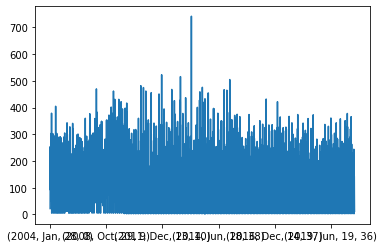

In [44]:
idx = []
p_clean = []
for f in data_c.fileids():
    year,month,day = re.search("(\d{4})(\d{2})(\d{2})",f).groups()
    for i,p in enumerate(data_c.paras(f)):
        idx.append((year,calendar.month_abbr[int(month)],day,i)) #Year,Month,Day,Paragraph number
        flat_p = [item for sublist in p for item in sublist]
        paragraph = ' '.join(flat_p)
        p_tokenized = simple_tokenizer(paragraph)
        p_clean.append([p_tokenized,flat_p])

df_clnpara = pd.DataFrame(data = p_clean,
                          index = pd.MultiIndex.from_tuples(idx), 
                          columns = ['tokenized text','old text'])

df_clnpara['old text'].apply(len).plot()

There's only one paragraph having tokens over 512 and others are below 512 tokens. Thus, it should be safe to truncate the maximum length of token in the bert model.

In [45]:
bert_vectors = None
try:
    bert_vectors = pd.read_pickle(file_path_prefix + 'data/minutes_bert_vectors.pkl.gz')
except:
    pass
df_clnpara.index = timestamps
df_clnpara_join = df_clnpara.join(df_yc_slope_changes)
raw_text_tokens = df_clnpara_join[~df_clnpara_join['slope_change'].isna()]['old text']


if IN_COLAB and bert_vectors is None:
    from transformers import DistilBertModel, DistilBertTokenizer
    MODEL_NAME = 'distilbert-base-uncased'
    # Load pre-trained model
    distil_model = DistilBertModel.from_pretrained(MODEL_NAME)
    # Load pre-trained model tokenizer (vocabulary)
    distil_tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
    #distil_model.to(device)
    
    st = 0
    batch_size = 5
    batches = list(range(batch_size, len(raw_text_tokens), batch_size))+[len(raw_text_tokens)]
    doc_rep_collector = []
    for b in batches:
        tokens = distil_tokenizer.batch_encode_plus(
            raw_text_tokens[st:b],
            pad_to_max_length=True, 
            return_tensors="pt",
            max_length=512,
            truncation=True)
        st = b
        #tokens.to(device)
        outputs = distil_model(**tokens)
        # taking the representation of the 'CLS' token (doc-level embedding)
        o = outputs[0][:,0].cpu().detach().numpy()
        doc_rep_collector.append(o)

    # stack into array
    doc_rep_collector = np.concatenate(doc_rep_collector)
    # to minimize size, can store as 16-bit float
    doc_rep_collector = doc_rep_collector.astype('float16')
    # additionally, will store as gzip (pandas can handle this)
    import gzip
    pickle.dump(doc_rep_collector, gzip.open(file_path_prefix + 'minutes_bert_vectors.pkl.gz', 'wb'))

In [46]:
bert_train_vecs = bert_vectors[indices_train]
bert_test_vecs = bert_vectors[indices_test]

bert_svc = SVC(random_state=42, class_weight='balanced')
bert_svc.fit(bert_train_vecs, is_steepen_train)
train_preds = bert_svc.predict(bert_train_vecs)
test_preds = bert_svc.predict(bert_test_vecs)

print('Bert Model Train accuracy:', accuracy_score(is_steepen_train, train_preds))
print('Bert Model Test accuracy:', accuracy_score(is_steepen_test, test_preds))
print(classification_report(is_steepen_test, test_preds))

Bert Model Train accuracy: 0.5509536784741145
Bert Model Test accuracy: 0.5340114431023522
              precision    recall  f1-score   support

       False       0.65      0.55      0.59       978
        True       0.41      0.51      0.45       595

    accuracy                           0.53      1573
   macro avg       0.53      0.53      0.52      1573
weighted avg       0.56      0.53      0.54      1573



The accuracy of Bert model is about 61%. Although GloVe, Elmo and Bert are more advanced models, Elmo and Bert could incoporate context as well, they're not even better then our baseline model(LDA model). The reason could be there're limited data which may not fully utilized the power of these model. And since these advanced models are trained on a general dataset and the minutes of FED are a very specialized domain which is kinda difficult to be captured by these pre-train models.

## <a name="minutes"></a>Use entire minitues rather than paragraphs

## <a name="TFIDF"></a>TFIDF

In [47]:
df_docs = pd.DataFrame(df_paragraphs.groupby(level=[0])['raw_text'].transform(lambda x: ' '.join(x)).drop_duplicates())
timestamps = df_docs.index.map(lambda x: str(x[0]))
df_docs.index = timestamps
df_docs_unstack = df_docs.join(df_yc_slope_changes)
df_docs_unstack = df_docs_unstack[~df_docs_unstack['slope_change'].isna()]

df_docs_unstack

,raw_text,slope_change,steepen
2004-02-18,The Committee then turned to a discussion of t...,-0.33,False
2004-04-06,The information reviewed at this meeting sugge...,-0.30,False
2004-05-25,The information reviewed at this meeting sugge...,0.03,True
2004-07-21,The information reviewed at this meeting sugge...,-0.29,False
2004-08-31,The information reviewed at this meeting sugge...,0.41,True
...,...,...,...
2019-10-09,Staff Review of the Economic Situation The in...,0.20,True
2019-11-20,Staff Review of the Economic Situation The inf...,-0.01,False
2020-02-19,Staff Review of the Economic Situation The inf...,-0.18,False
2020-05-20,Staff Review of the Economic Situation The cor...,-0.01,False


In [48]:
x = df_docs_unstack['raw_text']
y = df_docs_unstack['steepen'].astype('bool')
minutes_train, minutes_test, is_steepen_train, is_steepen_test = train_test_split(x, y, test_size=0.3, random_state=7)


In [49]:
tfidf = TfidfVectorizer(tokenizer=simple_tokenizer, lowercase = False)
tfidf_svc_vecs_train = tfidf.fit_transform(minutes_train).toarray()
tfidf_svc_vecs_test = tfidf.transform(minutes_test).toarray()

In [50]:
tfidf_svc_vecs_train.shape

(88, 5204)

In [51]:
is_steepen_train.shape

(88,)

In [52]:
tfidf_svc = SVC(random_state=42, probability=True, class_weight='balanced')
tfidf_svc.fit(tfidf_svc_vecs_train, is_steepen_train)
test_preds = tfidf_svc.predict(tfidf_svc_vecs_test)

In [53]:
print(classification_report(is_steepen_test, test_preds))

              precision    recall  f1-score   support

       False       0.72      0.54      0.62        24
        True       0.48      0.67      0.56        15

    accuracy                           0.59        39
   macro avg       0.60      0.60      0.59        39
weighted avg       0.63      0.59      0.59        39



## <a name="future"></a>GloVe and LSTM

In [54]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Embedding, Dense, SimpleRNN, LSTM
from keras import optimizers
from sklearn.utils.class_weight import compute_sample_weight

In [55]:
glove_vectors.shape

(5243, 300)

In [56]:
df_minutes = df_paragraphs_unstack.copy()
df_minutes['new_index'] = range(len(df_minutes))
encoded_docs_ge = df_minutes.groupby(level=[0])['new_index'].apply(np.array)
max(encoded_docs_ge.apply(len))

56

In [57]:
maxlen=56
padded_docs_ge = pad_sequences(encoded_docs_ge, maxlen=maxlen, padding='post')
padded_docs_ge = np.vstack(padded_docs_ge)
padded_docs_ge

array([[   0,    1,    2, ...,    0,    0,    0],
       [  29,   30,   31, ...,    0,    0,    0],
       [  56,   57,   58, ...,    0,    0,    0],
       ...,
       [5089, 5090, 5091, ...,    0,    0,    0],
       [5137, 5138, 5139, ...,    0,    0,    0],
       [5189, 5190, 5191, ..., 5242,    0,    0]], dtype=int32)

In [58]:
padded_docs_ge.shape

(127, 56)

In [59]:
labels = df_minutes.groupby(level=[0])['steepen'].first()
len(labels)

127

In [60]:
minutes_train, minutes_test, is_steepen_train, is_steepen_test = train_test_split(padded_docs_ge, labels, test_size=0.3, random_state=7)
class_wt = compute_sample_weight(class_weight = 'balanced', y = is_steepen_train)

In [61]:
from keras.regularizers import L1L2

vocab_size = glove_vectors.shape[0]
emdedding_size = glove_vectors.shape[1]

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=emdedding_size, 
                    input_length=maxlen,
                    weights=[glove_vectors],
                    trainable=False)
                    )
model.add(LSTM(units=emdedding_size, dropout=0.3, bias_regularizer=L1L2(l1=0, l2=0.02)))
model.add(Dense(1, activation='sigmoid'))

In [62]:
optimizer = optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])  # Compile the model
print(model.summary())  # Summarize the model
history = model.fit(minutes_train, is_steepen_train, epochs=200, verbose=0, sample_weight=class_wt, validation_split=0.3)  # Fit the model
loss, accuracy = model.evaluate(minutes_train, is_steepen_train, verbose=1)  # Evaluate the model
print('Accuracy: %0.3f' % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 56, 300)           1572900   
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 2,294,401
Trainable params: 721,501
Non-trainable params: 1,572,900
_________________________________________________________________
None
3/3 [==============================] - 0s 15ms/step - loss: 6.1414 - acc: 0.7500
Accuracy: 0.750


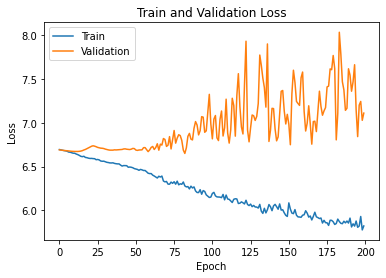

In [63]:
def plot_training_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Train and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
plot_training_history(history)

In [64]:
test_preds = model.predict(minutes_test) > 0.5
print(classification_report(is_steepen_test, test_preds))

              precision    recall  f1-score   support

       False       0.74      0.71      0.72        24
        True       0.56      0.60      0.58        15

    accuracy                           0.67        39
   macro avg       0.65      0.65      0.65        39
weighted avg       0.67      0.67      0.67        39



# <a name="deploy"></a>Deployment

We deployed topic model, sentiment model and spread prediction model.

In [65]:
sample = df_paragraphs['raw_text'][-9]
sample

'Participants also agreed that, to support the flow of credit to households and businesses, over coming months it would be appropriate for the Federal Reserve to increase its holdings of Treasury securities and agency MBS and agency CMBS at least at the current pace to sustain smooth market functioning, thereby fostering effective transmission of monetary policy to broader financial conditions. In addition, the Desk would continue to offer large-scale overnight and term repo operations. Participants noted that it would be important to continue to monitor developments closely and that the Committee would be prepared to adjust its plans as appropriate.'

In [66]:
lda_pipe = Pipeline([('vectorizer', CountVectorizer(tokenizer=lambda x: x, lowercase = False)), ('lda', LatentDirichletAllocation(n_components=6, random_state=7))])
lda_pipe.fit(df_paragraphs_unstack['tokenized_text'], df_paragraphs_unstack['steepen'].astype('bool'))
pickle.dump(lda_pipe, open(file_path_prefix + 'models/lda_pipe.pkl', 'wb'))

In [67]:
tfidf_svc_pipe = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=lambda x: x, lowercase = False)), ('svc', SVC(random_state=42, probability=True, class_weight='balanced'))])
tfidf_svc_pipe.fit(df_paragraphs_unstack['tokenized_text'], df_paragraphs_unstack['steepen'].astype('bool'))
pickle.dump(tfidf_svc_pipe, open(file_path_prefix + 'models/tfidf_svc_pipe.pkl', 'wb'))

In [68]:
lda_pipe.transform([simple_tokenizer(sample)])

array([[0.60703569, 0.08625413, 0.29789132, 0.00293274, 0.00294304,
        0.00294308]])

In [69]:
tfidf_svc_pipe.predict_proba([simple_tokenizer(sample)])

array([[0.751119, 0.248881]])

# <a name="future"></a>Future Work


As beginners of NLP, we are inspired by this project with a few takeaways. 

1. Try to predict other financial products: dollar index. next fed fund rates desicions. 
2. Calculate sentiment socres in realtime, predict sentiment score in a rea-time speech. Use Bayesian methods to update predictions after each paragraph of a speech.
